In [1]:
print("\n\nம ஹா ம்ரி த் யு ஞ் ஜ யா\n\n")



ம ஹா ம்ரி த் யு ஞ் ஜ யா




In [2]:
import Config
import Preprocessing
from Utils import mape, smape, rescaling

In [3]:
# Deep Ant Avg Fscore:
(0.46+0.94+0.87+0.68)/4


0.7375

In [4]:
# Mine Spectral Residual approach Avg Fscore:

#FULL DATA
#74.57% and 3.6 sec time execution on entire 367 TimeSeries data of Yahoo

#A1 = 32.23%
#A2 = 73.008%
#A3 = 91.19%
#A4 = 87.89%

#HALF DATA
# 73.2% and Time taken = 3.2845242023468018 seconds
#A1 = 27.78%
#A2 = 78.6%
#A3 = 89.25%
#A4 = 82.14%

In [5]:
# Mine Detrend + Spectral Residual approach Avg Fscore:

#77.9% and 3.58 sec time execution on entire 367 TimeSeries data of Yahoo

# Individual Fscore of Yahoo's A1, A2, A3, A4
#A1 = 32.55%
#A2 = 78.09%
#A3 = 95.41%
#A4 = 90.59%

#HALF DATA
# 75.12% and Time taken = 2.101639986038208 seconds
#A1 = 29.07%
#A2 = 78.65%
#A3 = 92.05%
#A4 = 85.55

In [6]:
#!pwd

In [7]:
import matplotlib
#matplotlib.use('nbagg')

In [8]:
import tensorflow as tf

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pickle, os, time, uuid
import pandas as pd
from pathlib import Path
from tensorflow.contrib.rnn import LSTMCell, GRUCell
import numpy as np
from sklearn.externals import joblib 


In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

In [10]:
tf.__version__

'1.14.0'

In [11]:
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A1Benchmark/'
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A2Benchmark/'

file='real_3.csv'
file='synthetic_18.csv'
df = pd.read_csv(os.path.join(path,file), header=0)

In [12]:
Xfull, Yfull, Xtr, Ytr, Xts, Yts, Xv, Yv, Xmax, Xmin, Y_anom_label_true = Preprocessing.data_preparation_Yahoo_80_10_10_split(df, file, forecasting_length=Config.forecast_len, detrend=Config.detrend_flag)

#Xfull.shape, Yfull.shape, len(Y_anom_label_true), Xtr.shape, Ytr.shape, Xts.shape, Yts.shape, Xv.shape, Yv.shape 

In [13]:
#Xfull, Yfull, Xtr, Ytr, Xts, Yts, Xv, Yv, Xmax, Xmin, Y_anom_label_true = Preprocessing.data_preparation_Yahoo_Benchmark(df, file, forecasting_length=Config.forecast_len, detrend=Config.detrend_flag)

#Xfull.shape, Yfull.shape, len(Y_anom_label_true), Xtr.shape, Ytr.shape, Xts.shape, Yts.shape, Xv.shape, Yv.shape 

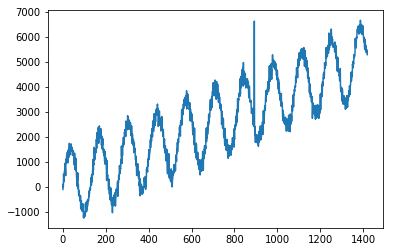

In [14]:

data_t = df.value.values

plt.plot(data_t)
plt.show()

In [15]:
seq_length = Xfull.shape[0]
out_length = Yfull.shape[0]        
# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = Yfull.shape[-1]
input_dim = Xfull.shape[-1]      

In [16]:
Xtr.shape, Ytr.shape, Xts.shape, Yts.shape, Xv.shape, Yv.shape

((48, 1097, 1),
 (1, 1097, 1),
 (48, 138, 1),
 (1, 138, 1),
 (48, 137, 1),
 (1, 137, 1))

In [17]:
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

In [18]:

with tf.compat.v1.variable_scope("Encoder") as scope:
    # Encoder: inputs
    enc_inp = [
        tf.compat.v1.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
        for t in range(seq_length)
    ]
    # Th encoder cell, multi-layered with dropout
    cells_enc = []
    for i in range(Config.layers_stacked_count_enc):
        cell_enc = LSTMCell(num_units=Config.hidden_dim_list_enc[i] )
        cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=1.0-Config.dropout_list[i])    
        cells_enc.append(cell_enc)
    cell_enc = tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells_enc)

    encoder_outputs, encoder_final_state = tf.compat.v1.nn.static_rnn(cell_enc,
                                              inputs=enc_inp, dtype=tf.float32)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:

with tf.compat.v1.variable_scope("Decoder") as scope:
    # Decoder: inputs    
    dummy_zero_input = [tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO_dummy_zero_input")]

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.compat.v1.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
        for t in range(out_length)
    ]

    w_out = tf.Variable(tf.random.normal([Config.out_hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random.normal([output_dim]))

    # The decoder, also multi-layered
    cells_dec = []
    for i in range(Config.layers_stacked_count_dec):
        cell_dec = LSTMCell(num_units=Config.hidden_dim_list_dec[i] )
        cell_dec = tf.contrib.rnn.DropoutWrapper(cell_dec, output_keep_prob=1.0-Config.dropout_list[i])    
        cells_dec.append(cell_dec)
    cell_dec = tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells_dec)

    decoder_outputs, decoder_final_state = tf.compat.v1.nn.static_rnn(cell_dec,
                                              inputs=dummy_zero_input, initial_state=encoder_final_state,
                                                                      dtype=tf.float32)

    reshaped_outputs = [(tf.matmul(i, w_out) + b_out) for i in decoder_outputs]



# Training loss and optimizer
with tf.compat.v1.variable_scope('Loss'):
    epsilon = 0.01  # Smoothing factor, helps SMAPE to be well-behaved near zero    
    true_o = expected_sparse_output
    pred_o = reshaped_outputs
    
#    summ = tf.maximum(tf.abs(true_o) , epsilon) 
#    smape_ = tf.abs(pred_o - true_o) / summ #* 2.0    
    
    denominator = tf.maximum( ( tf.abs(true_o) + tf.abs(pred_o) ) , epsilon )
    smape_ = tf.abs(pred_o - true_o) / denominator * 2.0  
    
    sloss =tf.compat.v1.losses.compute_weighted_loss(smape_, loss_collection=None)
    loss = sloss 

In [20]:
with tf.compat.v1.variable_scope('Loss'):
    # L2 loss
    loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))


In [21]:
learning_rate = 0.007  # Small lr helps not to diverge during training.
learning_rate = 0.01 

with tf.compat.v1.variable_scope('Optimizer'):  # AdamOptimizer
    optimizer = tf.compat.v1.train.RMSPropOptimizer(
        Config.learning_rate, decay=Config.lr_decay, momentum=Config.momentum)
    #optimizer = tf.train.AdamOptimizer(learning_rate)

    train_op = optimizer.minimize(loss)
    

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
checkpoint_file = 'maha'
#batch_size =128

In [23]:
def train_batchsize(Xtr, Ytr, batch_size=64):
    No_of_batches = int(Xtr.shape[1]/batch_size)
    No_of_batches, No_of_batches*batch_size
    for m in range(0, No_of_batches):
        start_index = m*batch_size
        end_index = start_index + batch_size
        
        Xtr_ = Xtr[:,start_index:end_index,:]
        Ytr_ = Ytr[:,start_index:end_index,:]
        
        feed_dict = {enc_inp[t]: Xtr_[t] for t in range(len(enc_inp))}
        #feed_dict.update({feats[t]: Xtr_f[t] for t in range(len(feats))} )
        feed_dict.update({expected_sparse_output[t]: Ytr_[
                         t] for t in range(len(expected_sparse_output))})

        _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batchsize(Xts, Yts):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op.
    """    
    #Xts_f = np.ones((1, Xts.shape[1], input_dim-1))
    feed_dict = {enc_inp[t]: Xts[t] for t in range(len(enc_inp))}
    #feed_dict.update({feats[t]: Xts_f[t] for t in range(len(feats))} )
    feed_dict.update({expected_sparse_output[t]: Yts[
                     t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]

In [24]:
nb_iters = 144
nb_iters = 96

In [25]:
import time

In [26]:
st = time.time()

In [27]:
# Training
train_losses = []
test_losses = []

sess.run(tf.compat.v1.global_variables_initializer())
cnt=0
early_stop = 36
Reps, Features = [], []
tmp_loss = []
for t in range(Config.nb_iters + 1):
    train_loss = train_batchsize(Xtr, Ytr, batch_size=Config.batch_size)
    train_losses.append(train_loss)    
    
    test_loss = test_batchsize(Xts, Yts)
    test_losses.append(test_loss)
    print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))
    #print(test_loss,np.min(test_losses[-30:]))
    
    if(test_loss<=np.min(test_losses) and len(test_losses)>20):
#    if(test_loss<=np.min(test_losses) and len(test_losses)>100):
#        saver.save(sess, checkpoint_file)
        print("model saved to path {}, train loss: {}, \tTEST loss: {}".format(checkpoint_file, train_loss, test_loss))
    if(np.min(test_losses)<np.min(test_losses[-early_stop:]) and len(test_losses)>early_stop):
        print("Stopped due to Early Stopping : Step {}/{}, train loss: {}, \tTEST loss: {}".format(t,nb_iters, train_loss, test_loss))
        break
    
print("Final. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))


Step 0/96, train loss: 6.103375434875488, 	TEST loss: 14.111992835998535
Step 1/96, train loss: 5.292441368103027, 	TEST loss: 10.445784568786621
Step 2/96, train loss: 4.504136562347412, 	TEST loss: 7.759781837463379
Step 3/96, train loss: 3.0922188758850098, 	TEST loss: 8.559167861938477
Step 4/96, train loss: 3.372922420501709, 	TEST loss: 5.581315994262695
Step 5/96, train loss: 1.9432315826416016, 	TEST loss: 3.080474615097046
Step 6/96, train loss: 1.64011812210083, 	TEST loss: 3.2330238819122314
Step 7/96, train loss: 1.6214110851287842, 	TEST loss: 2.0713326930999756
Step 8/96, train loss: 0.7554494142532349, 	TEST loss: 1.6924411058425903
Step 9/96, train loss: 0.9320953488349915, 	TEST loss: 1.025051474571228
Step 10/96, train loss: 0.2731900215148926, 	TEST loss: 0.49186962842941284
Step 11/96, train loss: 0.32252931594848633, 	TEST loss: 0.513756513595581
Step 12/96, train loss: 0.30110323429107666, 	TEST loss: 0.426179975271225
Step 13/96, train loss: 0.23634272813796997, 

In [28]:
print("Time taken = ", (time.time()-st)/60, "minutes")

Time taken =  0.6663189172744751 minutes


In [29]:
### MONTE CARLO Dropout
feed_dict = {enc_inp[t]: Xfull[t] for t in range(seq_length)}

uncertainty=[]
for rept in range(0, 24):
    outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    diff = ((Yfull - outputs) ** 2).mean()
    uncertainty.append(diff)
    
eta1 = np.sqrt(np.mean(uncertainty))
print("\n eta1 = ", eta1)

#validation Errors
feed_dict = {enc_inp[t]: Xv[t] for t in range(seq_length)}
#feed_dict.update({feats[t]: Xv_f[t] for t in range(len(feats))} )
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

eta2 = np.sqrt(((Yv - outputs) ** 2).mean())
print("\n eta2 = ", eta2)    

eta = np.sqrt( ((eta1)**2) + ((eta2)**2) )
print("\n Eta = ", eta)


 eta1 =  0.062355424712078285

 eta2 =  0.05798349782493059

 Eta =  0.08514860545562325


In [30]:
print("Time taken = ", (time.time()-st)/60, "minutes")

Time taken =  0.6943937381108601 minutes


In [31]:
uncertainty[0:6]

[0.003728035869884678,
 0.003975594915833889,
 0.003912151200396256,
 0.003826498342476837,
 0.0038635008683982866,
 0.0037894838475632385]

In [32]:
eta1, np.sqrt(uncertainty[8]), np.sqrt(uncertainty[6]), np.mean(uncertainty)

(0.062355424712078285,
 0.062161516491878295,
 0.06359317203541917,
 0.003888198991023663)

In [33]:
Yfull.shape

(1, 1372, 1)

In [34]:
anomaly_type_list = []
isanomaly_list = []
anomaly_score_list = []
output_list = []
upper_bound_list = []
lower_bound_list = []
actual_list = []

confidance_interval = 1.94
#confidance_interval = 1.64


feed_dict = {enc_inp[t]: Xfull[t] for t in range(seq_length)}
#feed_dict.update({feats[t]: Xfull_f[t] for t in range(len(feats))} )
outputs_full = np.array(sess.run([reshaped_outputs], feed_dict)[0])
Yfull_original = rescaling(Yfull,Xmax,Xmin)
outputs_original = rescaling(outputs_full,Xmax,Xmin)

anomaly_count=0
Is_anomaly_list = []
outputs_pred = outputs_full.reshape([-1])
Yfull_ = Yfull.reshape([-1])
Anoms_time_index = []
ind=0
for output_pred,actual in zip(outputs_pred,Yfull_):
    ind=ind+1
    upper_bound = float( output_pred + (confidance_interval*eta) )
    lower_bound = float( output_pred - (confidance_interval*eta) )
        
    if(actual<=upper_bound and actual>= lower_bound):
        Is_anomaly_list.append(0)
    else:
        Is_anomaly_list.append(1)
        anomaly_count = anomaly_count + 1
#        Anoms_time_index.append(Time_indices[ind])
        
#anomaly_count, len(Is_anomaly_list), np.count_nonzero(Is_anomaly_list)

print("Number of anomalies: = ", anomaly_count)

Number of anomalies: =  5


In [35]:
#true_y = Y_anom_label_true

true_y = df.is_anomaly.values[(len(df)-len(Is_anomaly_list)):]

In [36]:
prec_list, rec_list, f1score_list = [], [], []
prec_list.append(precision_score(true_y, Is_anomaly_list) )
rec_list.append(recall_score(true_y, Is_anomaly_list) )
f1score_list.append(f1_score(true_y, Is_anomaly_list) )

np.mean(prec_list), np.mean(rec_list), np.mean(f1score_list)

(0.0, 0.0, 0.0)

In [37]:
Yfull_original = rescaling(Yfull_,Xmax,Xmin)
outputs_pred_original = rescaling(outputs_pred,Xmax,Xmin)
Yfull_original.shape, outputs_pred_original.shape

((1372,), (1372,))

In [38]:
#outputs_full.shape, Yfull.shape, true_Yfull.shape, pred_y_full.shape

In [39]:
def get_score(y_true, y_pred):
    s = np.sqrt((y_true - y_pred)**2)
    
    return s

####### ANOM-DETECT:
true_Yfull = Yfull.reshape(Yfull.shape[1], 1)

feed_dict = {enc_inp[t]: Xfull[t] for t in range(seq_length)}
#feed_dict.update({feats[t]: Xfull_f[t] for t in range(len(feats))} )
pred_y_full = np.array(sess.run([reshaped_outputs], feed_dict)[0])

pred_y_full = pred_y_full.reshape(pred_y_full.shape[1], 1)

score = get_score(true_Yfull, pred_y_full)

pred_labels = []
for j in range(0, len(score)):
#    if score[j] <( np.mean(score) - 3.5*np.std(score) ) or score[j] >( np.mean(score) + 3.5*np.std(score) ):
    if score[j] <( np.mean(score) - 3*np.std(score) ) or score[j] >( np.mean(score) + 3*np.std(score) ):
#    if score[j] > np.percentile(score, 99):
        pred_labels.append(1)
    else:
        pred_labels.append(0)

#true_y = Y_anom_label_true # df.is_anomaly.values[(len(df)-len(Is_anomaly_list)):]

prec_list, rec_list, f1score_list = [], [], []
prec_list.append(precision_score(true_y, pred_labels) )
rec_list.append(recall_score(true_y, pred_labels) )
f1score_list.append(f1_score(true_y, pred_labels) )

np.mean(prec_list), np.mean(rec_list), np.mean(f1score_list)

(0.0, 0.0, 0.0)

In [40]:
pred_labels = []
for j in range(0, len(score)):
#    if score[j] <( np.mean(score) - 3.5*np.std(score) ) or score[j] >( np.mean(score) + 3.5*np.std(score) ):
#    if score[j] <( np.mean(score) - 3*np.std(score) ) or score[j] >( np.mean(score) + 3*np.std(score) ):
    if score[j] > np.percentile(score, 99):
        pred_labels.append(1)
    else:
        pred_labels.append(0)

#true_y = Y_anom_label_true # df.is_anomaly.values[(len(df)-len(Is_anomaly_list)):]

prec_list, rec_list, f1score_list = [], [], []
prec_list.append(precision_score(true_y, pred_labels) )
rec_list.append(recall_score(true_y, pred_labels) )
f1score_list.append(f1_score(true_y, pred_labels) )

np.mean(prec_list), np.mean(rec_list), np.mean(f1score_list)

(0.0, 0.0, 0.0)

# IMP info:

In [41]:
np.mean(score) - 3*np.std(score), np.mean(score) + 3*np.std(score)

(-0.07756409162594122, 0.1717835293375416)

In [42]:
lower_bound, upper_bound 

(0.013185697859175616, 0.3435622870269938)

In [51]:
plt.rcParams['figure.figsize'] = [20, 14]

# Original data

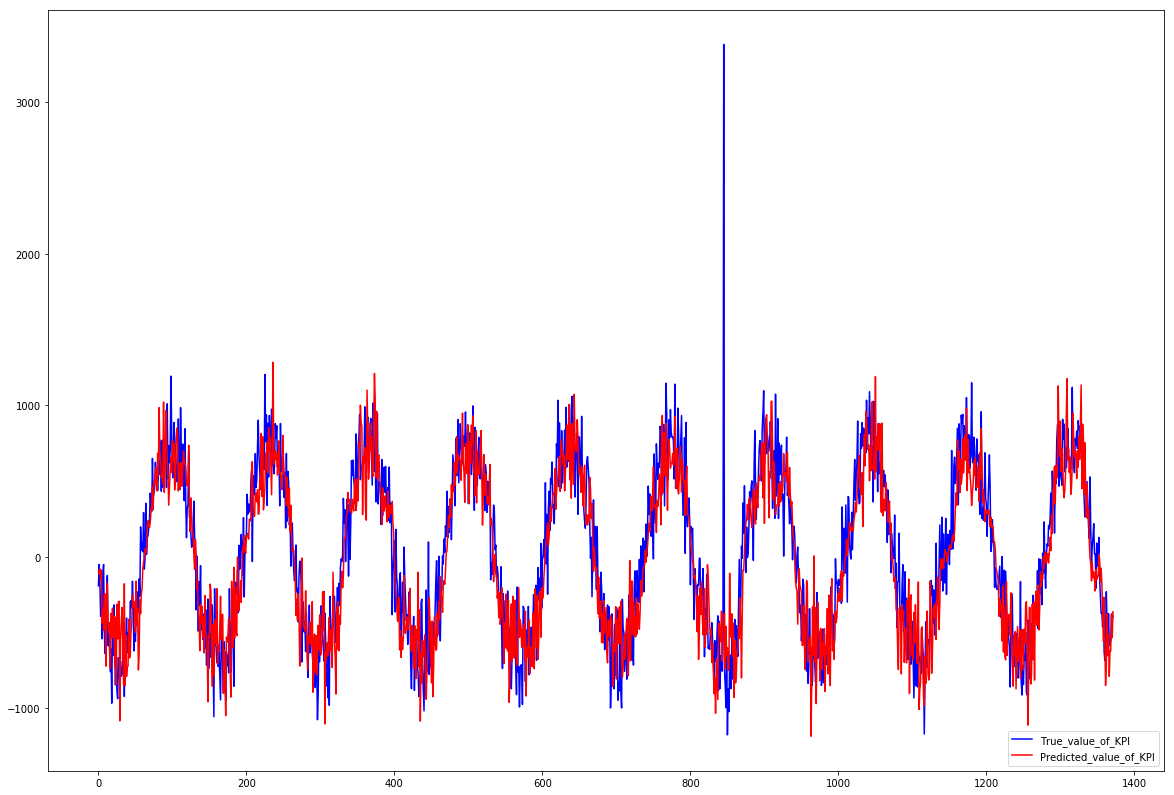

In [52]:
plt.plot(Yfull_original, color='blue', label='True_value_of_KPI')
plt.plot(outputs_pred_original, color='red', label='Predicted_value_of_KPI')
plt.legend(loc="lower right")
#plt.stem(Is_anomaly_list)
plt.show()

In [44]:
#!pip install mpld3

# scaled data

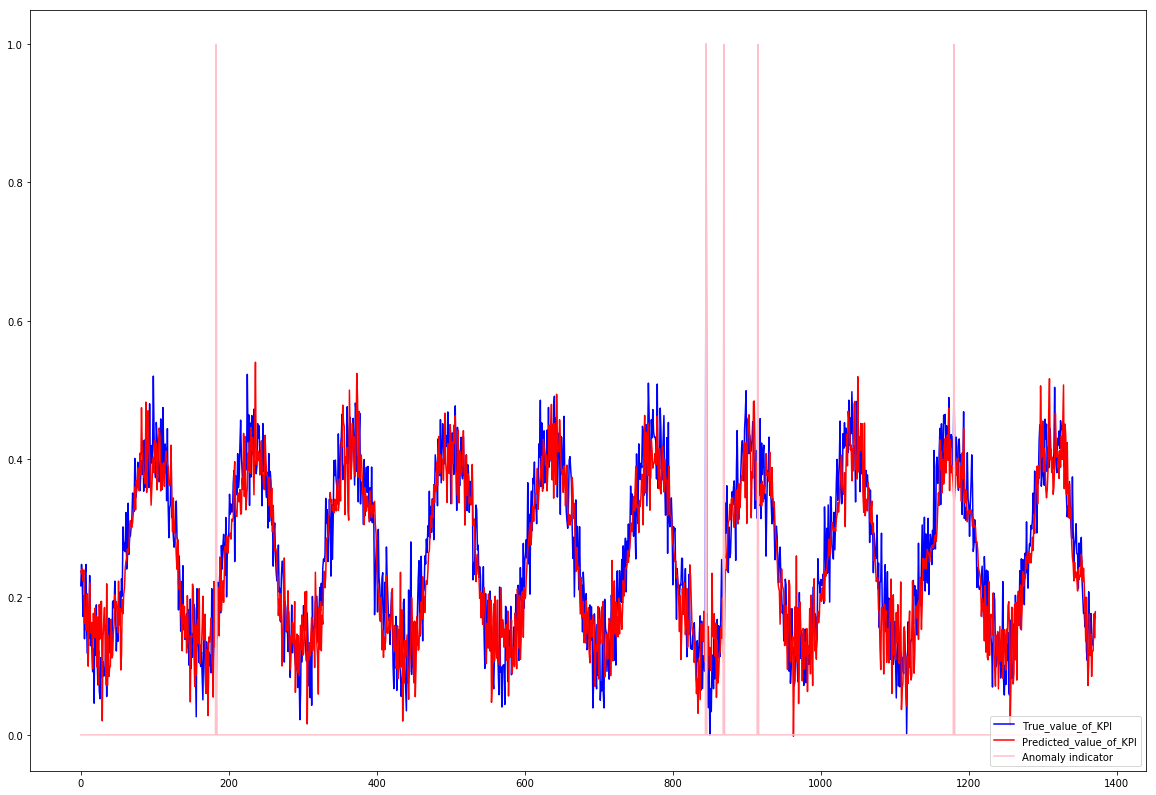

In [53]:
plt.plot(Yfull_, color='blue', label='True_value_of_KPI')
plt.plot(outputs_pred, color='red', label='Predicted_value_of_KPI')
plt.plot(Is_anomaly_list, color='pink', label ='Anomaly indicator')
plt.legend(loc="lower right")
plt.show()


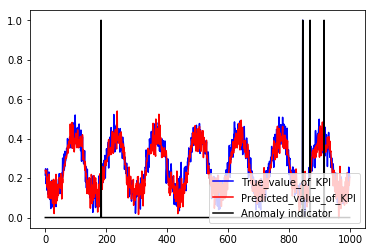

In [46]:
plt.plot(Yfull_[0:1000], color='blue', label='True_value_of_KPI')
plt.plot(outputs_pred[0:1000], color='red', label='Predicted_value_of_KPI')
plt.plot(Is_anomaly_list[0:1000], color='black', label ='Anomaly indicator')
plt.legend(loc="lower right")
plt.show()


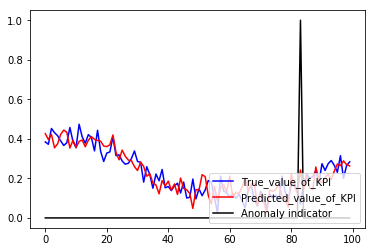

In [47]:
plt.plot(Yfull_[100:200], color='blue', label='True_value_of_KPI')
plt.plot(outputs_pred[100:200], color='red', label='Predicted_value_of_KPI')
plt.plot(Is_anomaly_list[100:200], color='black', label ='Anomaly indicator')
plt.legend(loc="lower right")
plt.show()

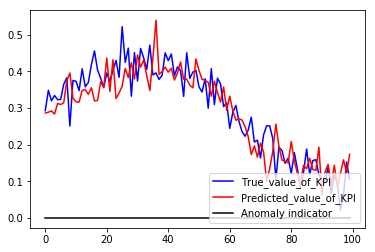

In [48]:
plt.plot(Yfull_[200:300], color='blue', label='True_value_of_KPI')
plt.plot(outputs_pred[200:300], color='red', label='Predicted_value_of_KPI')
plt.plot(Is_anomaly_list[200:300], color='black', label ='Anomaly indicator')
plt.legend(loc="lower right")
plt.show()

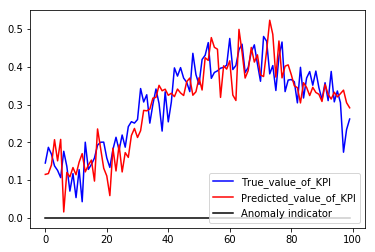

In [49]:
plt.plot(Yfull_[300:400], color='blue', label='True_value_of_KPI')
plt.plot(outputs_pred[300:400], color='red', label='Predicted_value_of_KPI')
plt.plot(Is_anomaly_list[300:400], color='black', label ='Anomaly indicator')
plt.legend(loc="lower right")
plt.show()

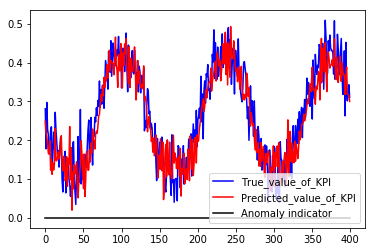

In [50]:
plt.plot(Yfull_[400:800], color='blue', label='True_value_of_KPI')
plt.plot(outputs_pred[400:800], color='red', label='Predicted_value_of_KPI')
plt.plot(Is_anomaly_list[400:800], color='black', label ='Anomaly indicator')
plt.legend(loc="lower right")
plt.show()